In [1]:
import os
import copy
import torch
from torchvision import transforms
from  torchvision.ops import box_iou
from util.augmentations import Compose
from util.data_aug import *
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import torchvision
from util.utils import box_iou
from util.actions_tree import Actor
import torch.nn.functional as F
from models.mnist_scale_model import Net_ae_proj, Agent_ae
from datasets.clutter_mnist_2digit_newdigit import MNIST_CoLoc
#from datasets.clutter_mnist_scale_rl import MNIST_CoLoc
from RL_entropy import get_policy_loss
import matplotlib.ticker as ticker

img_size = 84
num_cls = 10
batch_size = 5

os.environ['CUDA_VISIBLE_DEVICES']='6'

def convert_image_np(inp, norm=True):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    if norm:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
    return inp


In [2]:
def init_dataloader():
    kwargs = {'num_workers': 8, 'pin_memory': True}

    train_transform = Compose([Resize(84)])
    test_transform = Compose([Resize(84)])
    trainset = MNIST_CoLoc(root='.', train=True, digit=3, support_size=5, switch=1, 
                           bg_name='random_patch_2digit_34',sample_size='whole',
                           datapath='/research/cbim/vast/tl601/Dataset/Synthesis_mnist',
                           clutter=1)
                           #transform=train_transform)
    testset = MNIST_CoLoc(root='.', train=False, digit=3, switch=1,
                          bg_name='random_patch_2digit_34',
                          datapath='/research/cbim/vast/tl601/Dataset/Synthesis_mnist',
                          clutter=1)
    #transform=test_transform)

    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=512, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=512, shuffle=False, **kwargs)
    print('total train image: ', len(train_loader.dataset), ' test image: ',
          len(test_loader.dataset))
    return train_loader, test_loader

In [3]:
def init_model(hidden_size, dim, pretrained, freeze=1):
    net = Net_ae_proj(pooling_size=7, dim=dim,
              pooling_mode='align').to(device)
    agent = Agent_ae(rnn=1, poolsize=7,
                  num_class=10,
                  hidden_size=hidden_size).to(device)
    # if load pretrained encoder
    ckpt = torch.load(os.path.join('/research/cbim/vast/tl601/results/'
                                       'mnist/', pretrained))
                     
    if 'state_dict' in ckpt.keys():
        mnist_pretrained_dict = ckpt['state_dict']
    else:
        mnist_pretrained_dict = ckpt
    embeddingnet_dict = net.state_dict()

    filtered_dict = {}
    for k, v in mnist_pretrained_dict.items():
        if k in embeddingnet_dict:
            print('load ', k)
            filtered_dict[k] = v
    embeddingnet_dict.update(filtered_dict)
    net.load_state_dict(embeddingnet_dict)
    if 'state_dict' in ckpt.keys():
        if 'acc_inst' in ckpt.keys():
            print('loaded from {}\nckpt epoch {} acc {:.2f}%'.format(pretrained,
                                                                         ckpt['epoch'], ckpt['acc_inst']))
        elif 'acc_inst_fg' in ckpt.keys():
            print('loaded from {}\nckpt epoch {} acc {:.2f}%'.format(pretrained,
                                                                         ckpt['epoch'], ckpt['acc_inst_fg']))
        else:
            print('loaded from {}\nckpt epoch {} acc {:.2f}%'.format(pretrained,
                                                                         ckpt['epoch'], ckpt['acc']))
    else:
        print('loaded pretained MNIST encoder ', pretrained)

    if freeze == 1:
        for name, value in net.named_parameters():
            value.requires_grad = False

    return net, agent


In [23]:
hidden_size = 48
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, test_loader = init_dataloader()

pretrained = 'pretrain_ae_ord_proj_scp5_digit34_randpatch2d_shufproto_constrast_samp500_2ord_1m10_2m320_dim1024_hardneg/last.pth.tar'
model, agent4 = init_model(hidden_size, 1024, pretrained)
_, agent3 = init_model(hidden_size, 1024, pretrained)

# load model 
model_4 =  'ordinal_ae_fewshot_digit34_supp5_seq10_ent6pol1_2digitpatch_trainpatch_500_shufprotoemb_2ord1m10_2m320Dim1024HR_shufprotoRew_tar4_scratch' # not work
saveroot = '/research/cbim/vast/tl601/results/selfpaced/ordinal/'
model_path = os.path.join(saveroot, model_4, 'best.pth.tar')
print('loading ckpt from ', model_path)
ckpt = torch.load(model_path)
state_dict = ckpt['state_dict']
epoch = ckpt['epoch']
best_loss = ckpt['acc']
agent4.load_state_dict(state_dict)
print(("=> loaded checkpoint epoch {} {}".format(epoch, best_loss)))

model_3 = 'ordinal_ae_fewshot_digit34_supp5_seq10_ent6pol1_2digitpatch_trainpatch_500_shufprotoemb_2ord1m10_2m320Dim1024HR_shufprotoRew_tar3_scratch'
saveroot = '/research/cbim/vast/tl601/results/selfpaced/ordinal/'
model_path = os.path.join(saveroot, model_3, 'best.pth.tar')
print('loading ckpt from ', model_path)
ckpt = torch.load(model_path)
state_dict = ckpt['state_dict']
epoch = ckpt['epoch']
best_loss = ckpt['acc']
agent3.load_state_dict(state_dict)
print(("=> loaded checkpoint epoch {} {}".format(epoch, best_loss)))

loading random_patch_2digit_34 data... 
loading random_patch_2digit_34 data... 
total train image:  6131  test image:  1010
load  encoder.0.weight
load  encoder.0.bias
load  encoder.2.weight
load  encoder.2.bias
load  encoder.4.weight
load  encoder.4.bias
load  RCNN_top.0.weight
load  RCNN_top.0.bias
load  RCNN_top.3.weight
load  RCNN_top.3.bias
loaded from pretrain_ae_ord_proj_scp5_digit34_randpatch2d_shufproto_constrast_samp500_2ord_1m10_2m320_dim1024_hardneg/last.pth.tar
ckpt epoch 199 acc 93.66%
load  encoder.0.weight
load  encoder.0.bias
load  encoder.2.weight
load  encoder.2.bias
load  encoder.4.weight
load  encoder.4.bias
load  RCNN_top.0.weight
load  RCNN_top.0.bias
load  RCNN_top.3.weight
load  RCNN_top.3.bias
loaded from pretrain_ae_ord_proj_scp5_digit34_randpatch2d_shufproto_constrast_samp500_2ord_1m10_2m320_dim1024_hardneg/last.pth.tar
ckpt epoch 199 acc 93.66%
loading ckpt from  /research/cbim/vast/tl601/results/selfpaced/ordinal/ordinal_ae_fewshot_digit34_supp5_seq10_ent6

dist fg to bg  tensor([252.34, 323.10, 358.64, 348.23, 356.64], device='cuda:0')


/research/cbim/vast/tl601/anaconda3/envs/torch_ml/lib/python3.6/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


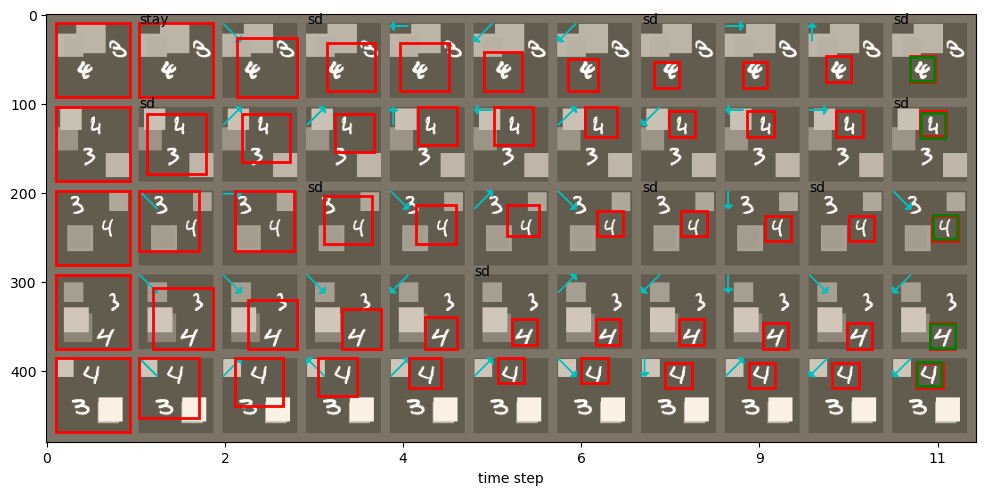

In [24]:
# compute embedding
supp_data, supp_target = train_loader.dataset.supp_data.to(device), \
                         train_loader.dataset.supp_targets.float()
rois_t0 = torch.cat((torch.arange(0, supp_data.shape[0]).float().view(-1, 1),
                     supp_target), dim=1).to(device)
with torch.no_grad():
    supp_embed, supp_top_feat = model(supp_data, rois_t0) # (support_size, 512)
    supp_embed = supp_embed.view(supp_embed.shape[0], -1)

proto_feat = torch.mean(supp_top_feat, dim=0) # (512,)

# visualize actions
torch.set_printoptions(precision=2, threshold=10000)
seq_len = 10
num = 5
batch_size = 512
with torch.no_grad():
    model.eval()
    agent4.eval()
    data_org, target_org = next(iter(test_loader))
    #target_org = target_org[target_org[:, :, -1] == 3][:, :-1]
    data_org, target_org = data_org.to(device), target_org.to(device).float().squeeze()
    data, target = data_org[:num], target_org[:num].clone()
    img = convert_image_np(torchvision.utils.make_grid(data.repeat(1, seq_len+1, 1, 1).view(num*(seq_len+1),
                                1, data.shape[2], data.shape[3]).cpu(), nrow=seq_len+1,
                                    padding=10), norm=True)

    fig = plt.figure(figsize=(12, 8), dpi= 100)
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)

    state = data_org.clone()
    all_embed, logits_seq = [], []
    pred_boxes = torch.tensor([[0,0,83,83]]).float().repeat(batch_size, 1)
    boxes = [pred_boxes]
    rois = torch.cat((torch.arange(0, batch_size).float().view(-1, 1).to(device),
                          pred_boxes.to(device)), dim=1)
    org_boxes = pred_boxes.clone().to(device)
    rois_t0 = torch.cat((torch.arange(0, batch_size).unsqueeze(1).repeat(1,2).view(-1, 1).to(device),
                            target_org.view(-1, 5)[:, :4].to(device)), dim=1)
    action_seq = torch.IntTensor(batch_size, seq_len).to(device)
    rewards_all = torch.zeros((batch_size, seq_len+1)).to(device)
    rewards_supp_all = torch.zeros((batch_size, seq_len+1)).to(device)
    actor = Actor(data_org, min_box_side=28)
    if hidden_size:
        h_t = torch.zeros(
            batch_size,
            hidden_size,
            dtype=torch.float,
            device=device,
            requires_grad=True,
        )
    # 1st forward classifier
    with torch.no_grad():
        embed_t, top_feat_t_all = model(data_org, rois_t0) # top_feat_t, (2bs, dim)
        embed, top_feat = model.get_roi_embedding(rois)
    top_feat_t_fg, top_feat_t_bg = top_feat_t_all.view(batch_size, 2, -1)[:,0], \
                                   top_feat_t_all.view(batch_size, 2, -1)[:,1]
    print('dist fg to bg ', F.pairwise_distance(top_feat_t_fg, top_feat_t_bg)[:num] )
    rewards_all[:, 0] = F.pairwise_distance(top_feat_t_bg, top_feat)
    rewards_supp_all[:, 0] = F.pairwise_distance(proto_feat, top_feat)

    for t in range(seq_len):
        if hidden_size:
            h_t, logits, actions = agent4(embed, h_t_prev=h_t)
        else:
            logits, actions = agent4(embed)
       
        state, pred_boxes = actor.takeaction(actions)
        rois = torch.cat((torch.arange(0, batch_size).float().view(-1, 1).to(device),
                          pred_boxes.to(device)), dim=1)
        with torch.no_grad():
            embed, top_feat = model.get_roi_embedding(rois)
        all_embed.append(top_feat)
        rewards_all[:, t+1] = F.pairwise_distance(top_feat_t_bg, top_feat)
        #rewards_all[:, t+1] = F.pairwise_distance(embed_t, embed)
        action_seq[:, t] = actions.view(1, -1)
        logits_seq.append(logits)
        boxes.append(pred_boxes)
        
    rewards_trns = F.pairwise_distance(proto_feat, torch.cat(all_embed))
    rewards_supp_all[:, 1:] = rewards_trns.view(-1, batch_size).permute(1,0)
    
    boxes_copy = copy.deepcopy(boxes)
    target_copy = copy.deepcopy(target)
    for t in range(len(boxes)):
        for i, b in enumerate(boxes[t][:num]): # (num ,4)
            change_y = i * (img_size+10) + 10
            change_x = t * (img_size+10) + 10
            b[1::2] += change_y # change y1, y2
            b[::2] += change_x     # 
            #print('t ', t, ' change_y ', change_y, ' change_x ', change_x)
            
            if t>0:
                if action_seq[i, t-1] == 0: #shrink towards TL
                    plt.arrow(change_x+20, change_y+20, -20, -20, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 1: #shrink towards TR
                    plt.arrow(change_x, change_y+20, 20, -20, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 2: #shrink toward bottom left
                    plt.arrow(change_x+20, change_y, -20, 20, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 3: #shrink toward bottom right 
                    plt.arrow(change_x, change_y, 20, 20, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 4: # scale down
                    plt.text(change_x, change_y, 'sd')
                elif action_seq[i,t-1] == 5: #stay 
                    plt.text(change_x, change_y, 'stay')
                elif action_seq[i,t-1] == 6: #left 
                    plt.arrow(change_x+20, change_y+3, -20, 0, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 7: # right
                    plt.arrow(change_x, change_y+3, 20, 0, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 8: # up
                    plt.arrow(change_x+3, change_y+20, 0, -20, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 9: # down
                    plt.arrow(change_x+3, change_y, 0, 20, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 10: # higher
                    plt.text(change_x, change_y, 'higher')
                elif action_seq[i,t-1] == 11: # wider
                    plt.text(change_x, change_y, 'wider')
                elif action_seq[i,t-1] == 12: # narrower
                    plt.text(change_x, change_y, 'narrower')
                elif action_seq[i,t-1] == 13: # shorter
                    plt.text(change_x, change_y, 'shorter')
            
    target = target[:, 1, :-1]
    for i in range(target.shape[0]):
        target[i, 1::2] += i * (img_size+10) + 10
        target[i, ::2]  += seq_len * (img_size+10) + 10
    
    for box in boxes:
        for x1, y1, x2, y2 in box[:num]:
            patch = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2,
                              edgecolor='r', facecolor='none', fill=False)
            ax.add_patch(patch)
            
    for x1, y1, x2, y2 in target:
        patch = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2,
                              edgecolor='g', facecolor='none', fill=False)
        ax.add_patch(patch)
    
    ax.set_xlabel('time step')
    scale_x = img_size + 10
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x / scale_x))
    ax.xaxis.set_major_formatter(ticks_x)
    plt.show()

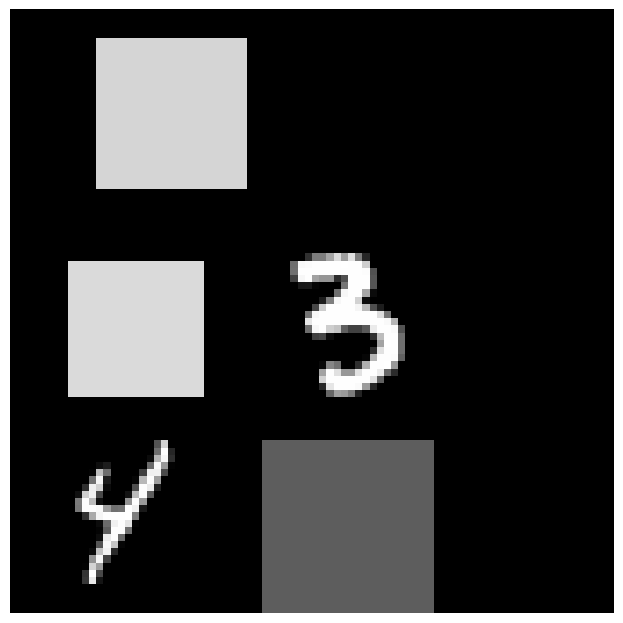

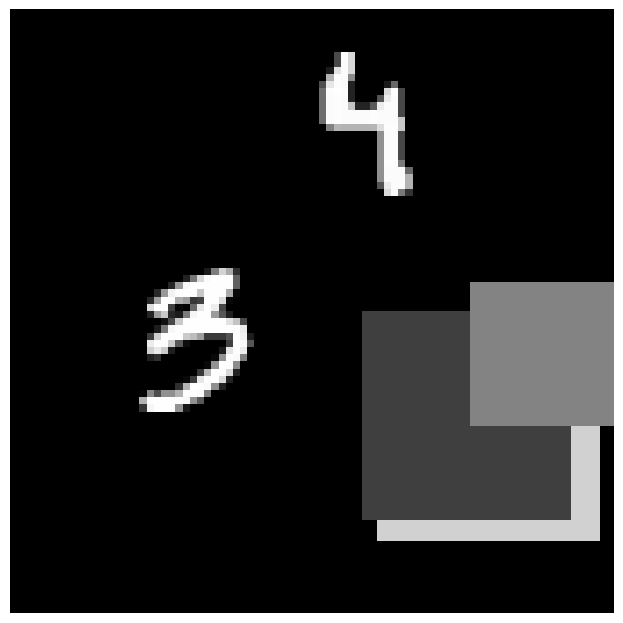

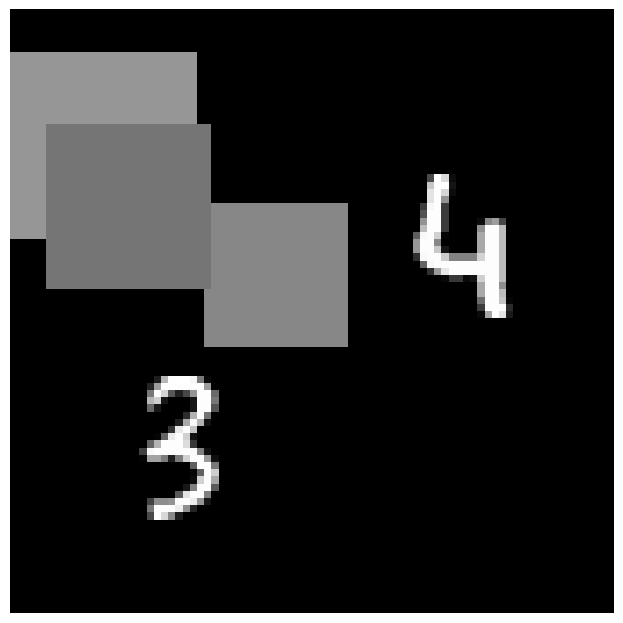

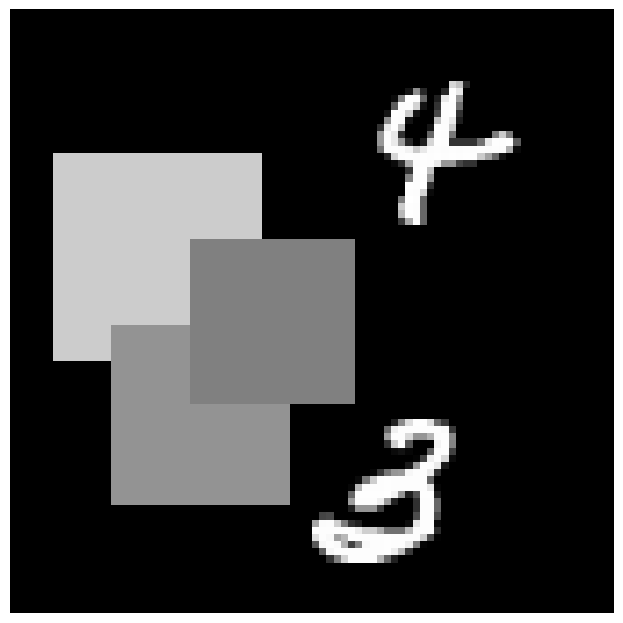

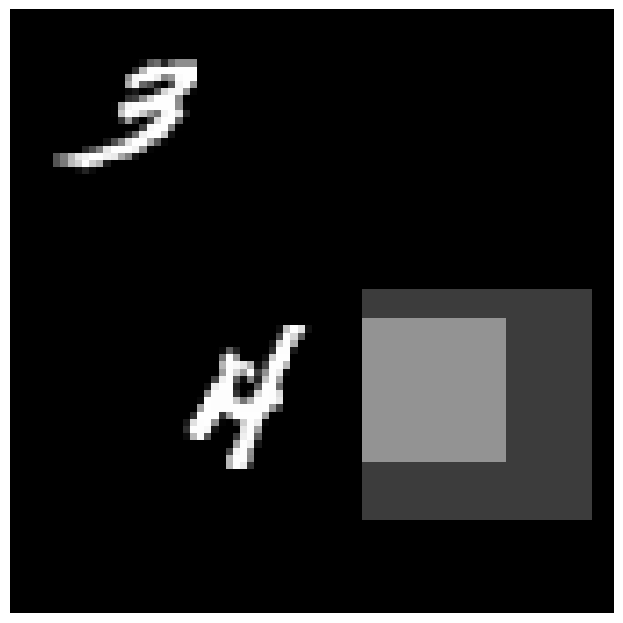

In [25]:
# plot support data
for i in range(len(supp_data)):
    img = convert_image_np(supp_data[i].cpu(), norm=False)
    fig = plt.figure(figsize=(12, 8), dpi= 100)
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img, cmap='gray')
    ax.set_axis_off()
    plt.savefig('supp_{}.png'.format(i), bbox_inches='tight', dpi=400)

In [26]:
def localize(model, agent, data, target):
    # visualize actions
    torch.set_printoptions(precision=2, threshold=10000)
    seq_len = 10
    with torch.no_grad():
        model.eval()
        agent.eval()
        data, target = data.to(device), target.to(device)
        batch_size = data.shape[0]
        

        state = data.clone()
        all_embed = []
        logits_seq = []
        pred_boxes = torch.tensor([[0,0,img_size-1,img_size-1]]).float().repeat(batch_size, 1)
        boxes = [pred_boxes]
        rois = torch.cat((torch.arange(0, batch_size).float().view(-1, 1).to(device),
                              pred_boxes.to(device)), dim=1)
        org_boxes = pred_boxes.clone().to(device)

        action_seq = torch.IntTensor(batch_size, seq_len).to(device)
        rewards_supp_all = torch.zeros((batch_size, seq_len+1)).to(device)
        actor = Actor(data, min_box_side=28)
        if hidden_size:
            h_t = torch.zeros(
                batch_size,
                hidden_size,
                dtype=torch.float,
                device=device,
                requires_grad=True,
            )
        # 1st forward classifier
        with torch.no_grad():
            embed, top_feat = model.get_roi_embedding(rois)

        for t in range(seq_len):
            if hidden_size:
                h_t, logits, actions = agent(embed, h_t_prev=h_t)
            else:
                logits, actions = agent(embed)

            state, pred_boxes = actor.takeaction(actions)
            rois = torch.cat((torch.arange(0, batch_size).float().view(-1, 1).to(device),
                              pred_boxes.to(device)), dim=1)
            with torch.no_grad():
                embed, top_feat = model.get_roi_embedding(rois)
            all_embed.append(top_feat)
            action_seq[:, t] = actions.view(1, -1)
            logits_seq.append(logits)
            boxes.append(pred_boxes)
    return pred_boxes

In [30]:
print('target_org ', target_org[:5])
pred_boxes_4 = localize(model, agent4, data, target_org)
print('pred_boxes_4 ', pred_boxes_4)
pred_boxes_3 = localize(model, agent3, data, target_org)
print('pred_boxes_3 ', pred_boxes_3)

target_org  tensor([[[56., 15., 83., 42.,  3.],
         [19., 38., 46., 65.,  4.]],

        [[25., 40., 52., 67.,  3.],
         [31.,  7., 58., 34.,  4.]],

        [[11.,  1., 38., 28.,  3.],
         [45., 27., 72., 54.,  4.]],

        [[53., 17., 80., 44.,  3.],
         [42., 55., 69., 82.,  4.]],

        [[15., 40., 42., 67.,  3.],
         [27.,  4., 54., 31.,  4.]]], device='cuda:0')
pred_boxes_4  tensor([[18., 36., 46., 64.],
        [31.,  6., 59., 34.],
        [44., 23., 72., 51.],
        [44., 52., 72., 80.],
        [25.,  0., 59., 34.]])
pred_boxes_3  tensor([[54., 14., 83., 42.],
        [22., 40., 50., 68.],
        [ 8.,  0., 36., 29.],
        [49., 14., 79., 42.],
        [16., 36., 44., 65.]])


/research/cbim/vast/tl601/anaconda3/envs/torch_ml/lib/python3.6/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


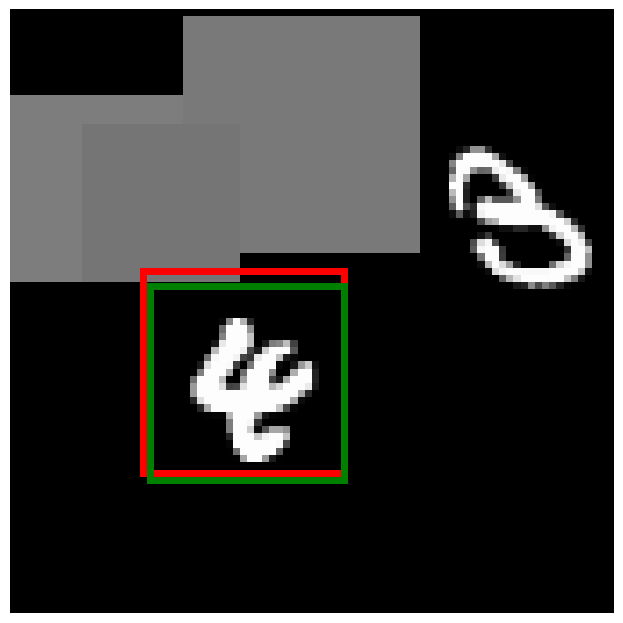

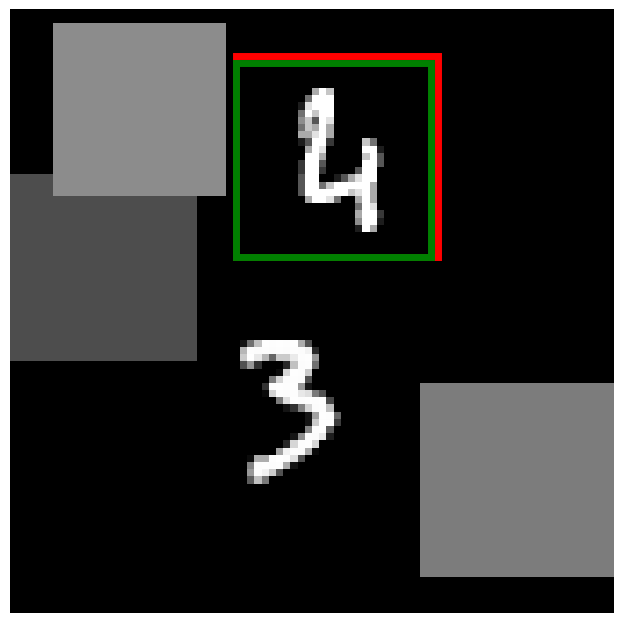

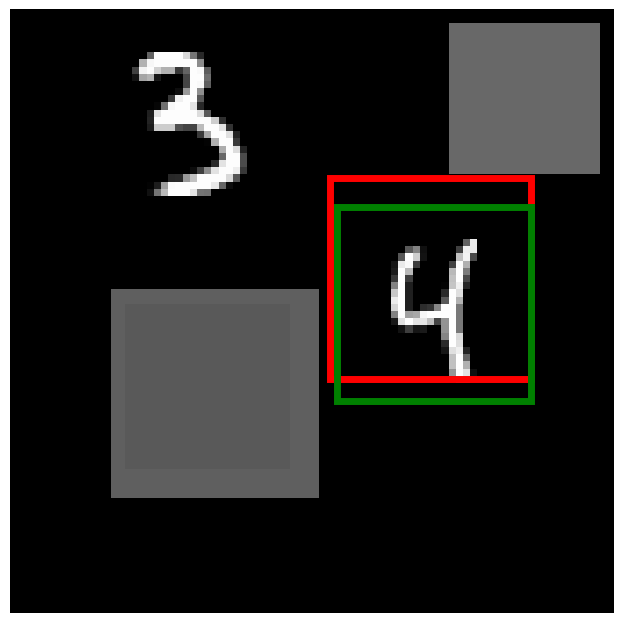

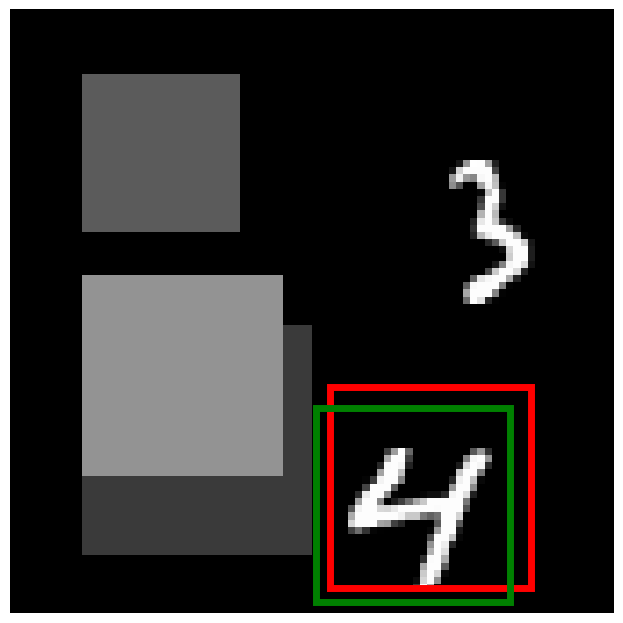

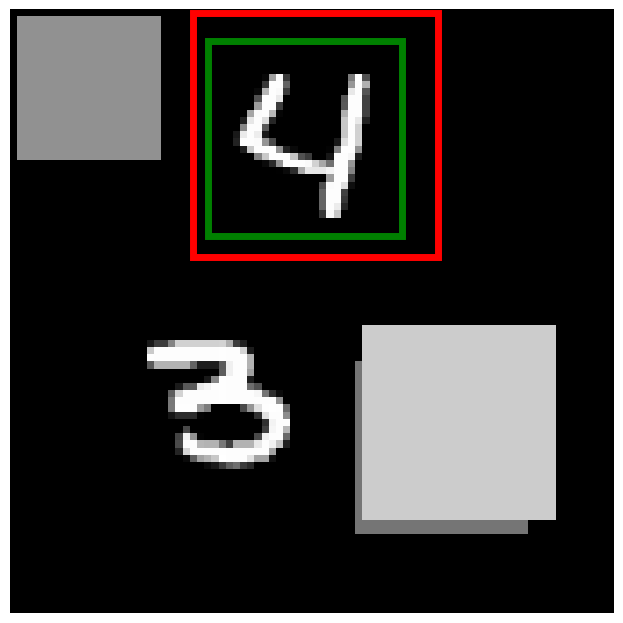

In [36]:
for i in range(len(data[:5])):
    img = convert_image_np(data[i].cpu(), norm=False)
    fig = plt.figure(figsize=(12, 8), dpi= 100)
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img, cmap='gray')
    ax.set_axis_off()
    x1, y1, x2, y2 = pred_boxes_4[i]
    patch = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=5,
                      edgecolor='r', facecolor='none', fill=False)
    ax.add_patch(patch)
    x1, y1, x2, y2, _ = target_org[i, 1]
    patch = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=5,
                      edgecolor='g', facecolor='none', fill=False)
    ax.add_patch(patch)
            
    plt.savefig('loc4_{}.png'.format(i), bbox_inches='tight', dpi=400)

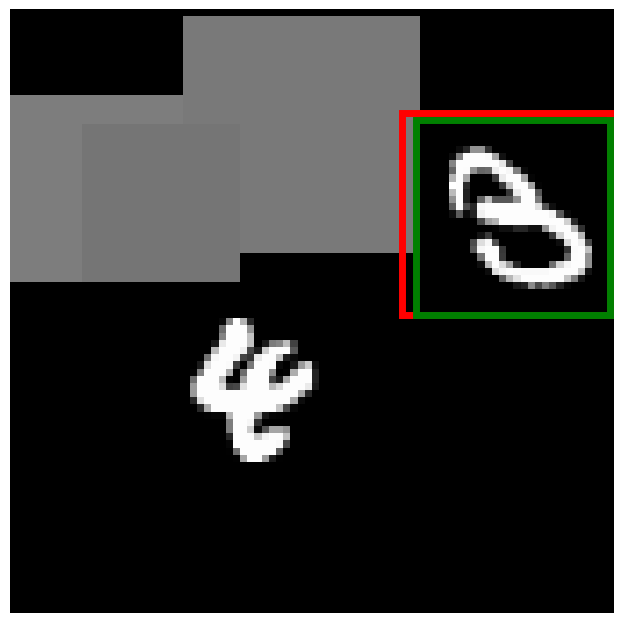

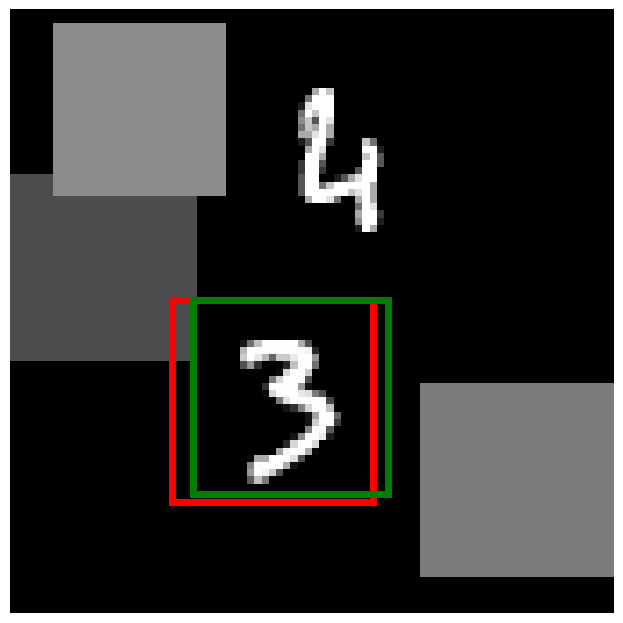

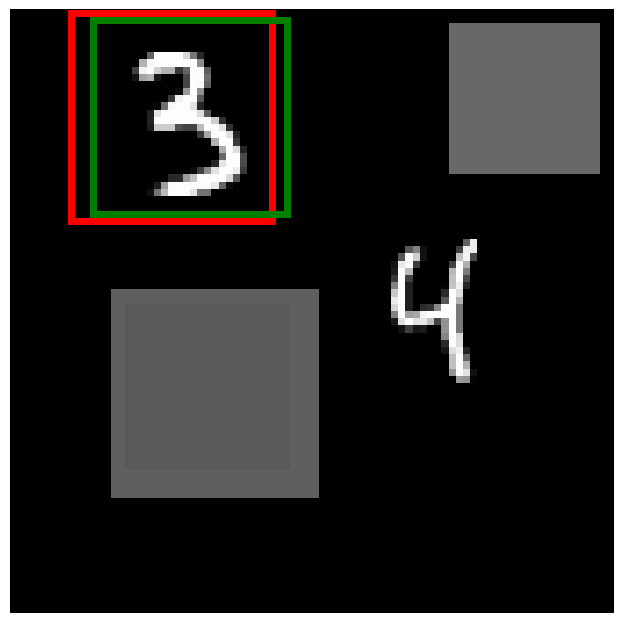

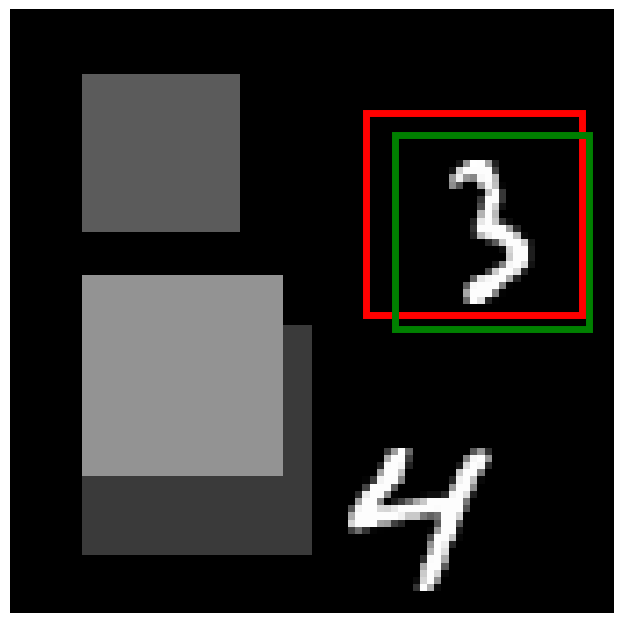

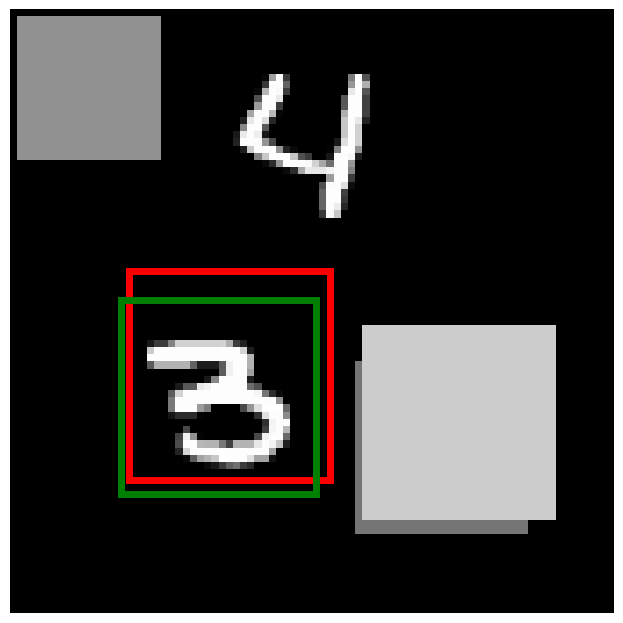

In [37]:
for i in range(len(data[:5])):
    img = convert_image_np(data[i].cpu(), norm=False)
    fig = plt.figure(figsize=(12, 8), dpi= 100)
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img, cmap='gray')
    ax.set_axis_off()
    x1, y1, x2, y2 = pred_boxes_3[i]
    patch = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=5,
                      edgecolor='r', facecolor='none', fill=False)
    ax.add_patch(patch)
    x1, y1, x2, y2, _ = target_org[i, 0]
    patch = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=5,
                      edgecolor='g', facecolor='none', fill=False)
    ax.add_patch(patch)
            
    plt.savefig('loc3_{}.png'.format(i), bbox_inches='tight', dpi=400)

rewards_all  tensor([12.00, 14.67, 46.34, 13.61,  3.95], device='cuda:0')


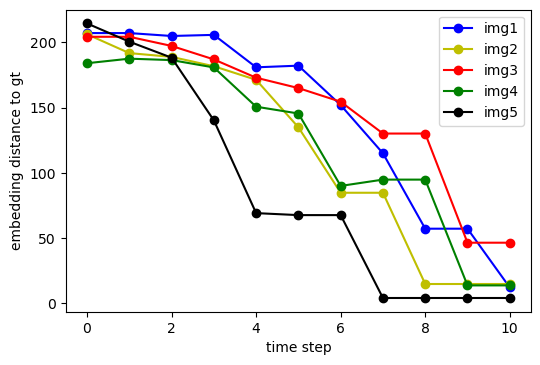

In [6]:
# plot rewards_all, i.e., distance to target
colors = ['b', 'y','r','g','k']
fig = plt.figure(dpi= 100)
ax = fig.add_subplot(1, 1, 1)
print('rewards_all ', rewards_all[:5, -1].view(-1))
for i, r in enumerate(rewards_all[:5].cpu().numpy()):
    plt.plot(range(seq_len+1), r, colors[i], label="img{}".format(i+1), marker='o')
plt.legend()
plt.xlabel('time step')
plt.ylabel('embedding distance to gt')
plt.show()

rewards_supp_all  tensor([11.35,  8.25, 40.35, 28.88, 10.88], device='cuda:0')


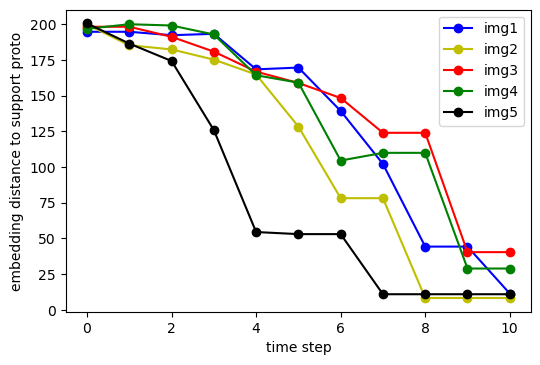

In [7]:
colors = ['b', 'y','r','g','k']
fig = plt.figure(dpi= 100)
ax = fig.add_subplot(1, 1, 1)
print('rewards_supp_all ', rewards_supp_all[:5, -1].view(-1))
for i, r in enumerate(rewards_supp_all[:5].cpu().numpy()):
    plt.plot(range(seq_len+1), r, colors[i], label="img{}".format(i+1), marker='o')
plt.legend()
plt.xlabel('time step')
plt.ylabel('embedding distance to support proto')
plt.show()

RuntimeError: shape '[-1, 4]' is invalid for input of size 10

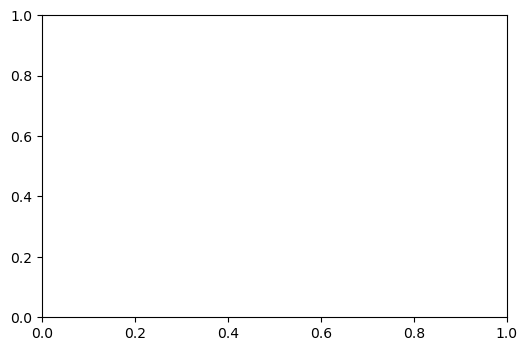

In [8]:
# plot iou
boxes_copy = torch.stack(boxes_copy).permute(1,0,2)[:5]
colors = ['b', 'y','r','g','k']
fig = plt.figure(dpi= 100)
ax = fig.add_subplot(1, 1, 1)
for i in range(5):
    ious = box_iou(boxes_copy[i].view(-1, 4), target_org[i].view(-1,4).cpu())
    plt.plot(range(seq_len+1), ious.view(-1).numpy(), colors[i], label="img{}".format(i+1), marker='o')
plt.legend()
plt.xlabel('time step')
plt.ylabel('IoU')
plt.show()